In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

In [3]:
# generate a random sequence of numbers around a value
mu = 15
stdev = 3

X = np.random.normal(mu, stdev, 50)
Y = np.random.normal(mu - 10, stdev, 50)
lb = np.min(Y) * 0.9
ub = np.max(X) * 1.1

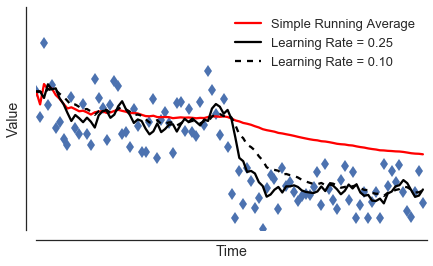

In [9]:

# set the learning rates of the models!
learning_rate0 = 0.25
learning_rate1 = 0.10

# create a simple RL Agent
XY = np.concatenate([X, Y])
mle = [np.mean(XY[0:ii]) for ii in range(1, len(XY) + 1)]

v = X[0]
q = []
for X0 in XY:
    q.append(v)
    v += learning_rate0 *(X0 - v)

v = X[0]
eta = 0.1
q2 = []
for X0 in XY:
    q2.append(v)
    v += learning_rate1 *(X0 - v)
    

with sns.axes_style('ticks'):
    plt.figure(figsize=(7, 4))
    plt.plot(XY, 'd')
    plt.plot(mle, 'r', label='Simple Running Average')
    plt.plot(q, 'k', label='Learning Rate = %.2f' % learning_rate0)
    plt.plot(q2, 'k--', label='Learning Rate = %.2f' % learning_rate1)
    ax = plt.gca()
    lb, ub = ax.get_ylim()
    ax.set_ylim([0, ub])
    ax.set_yticks([])
    ax.set_xticks([])
    sns.despine(trim=True, offset=10)
    ax.set_ylabel('Value')
    ax.set_xlabel('Time')
    plt.legend()

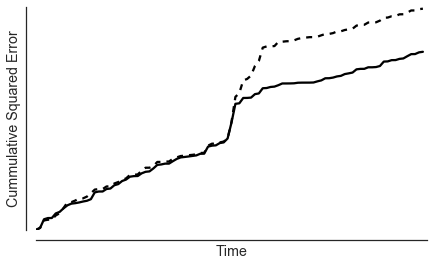

In [10]:
ml_error = []
q_error = []
q2_error = []

for ii, X0 in enumerate(XY):
    ml_error.append((X0-mle[ii])**2)
    q_error.append((X0-q[ii])**2)
    q2_error.append((X0-q2[ii])**2)
    

with sns.axes_style('ticks'):
    plt.figure(figsize=(7, 4))
#     plt.plot(np.cumsum(ml_error), 'r', label='Simple Running Average')
    plt.plot(np.cumsum(q_error), 'k', label='Learning Rate = %.2f' % learning_rate0)
    plt.plot(np.cumsum(q2_error), 'k--', label='Learning Rate = %.2f' % learning_rate1)
    ax = plt.gca()
    ax.set_yticks([])
    ax.set_ylabel('Cummulative Squared Error')
    ax.set_xticks([])
#     ax.set_ylim([0, 900])
    ax.set_xlabel('Time')
    sns.despine(trim=True, offset=10)
    plt.savefig('D8.png', dpi=300)

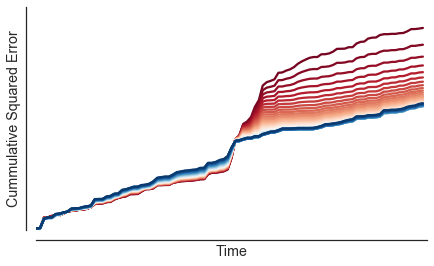

In [11]:

etas =  np.arange(0.05, 0.51, 0.01)

CC = sns.color_palette('RdBu', len(etas)) 
with sns.axes_style('ticks'):
    plt.figure(figsize=(7, 4))

    for ii, eta in enumerate(etas):
        q_error = []
        v = 15
        for X0 in XY:
            q_error.append((X0-v)**2)
            v += eta *(X0 - v)
        plt.plot(np.cumsum(q_error), color=CC[ii])
        
    ax = plt.gca()
    ax.set_yticks([])
#     ax.set_ylim([0, 900])
    ax.set_ylabel('Cummulative Squared Error')
    ax.set_xticks([]) 
    ax.set_xlabel('Time')
    sns.despine(trim=True, offset=10)
    plt.savefig('D8b.png', dpi=300)

# Learning rate as forgetting
A higher learning rate weights more recent experiences more strongly and decays experiences more distant in time more quickly. Specifically, the contribution (weight) of an observation to an learned value is at time $t-k$ is equal to

$$ w(X_{t-k}) = \eta(1-\eta)^{k} $$

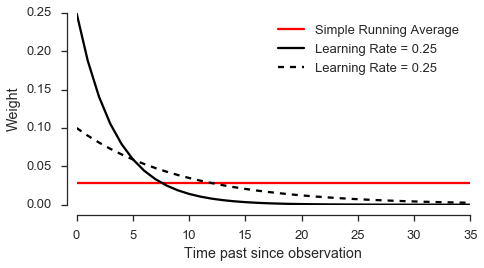

In [135]:
def weight(eta, k):
    return eta * ((1-eta)**k)


with sns.axes_style('ticks'):
    plt.figure(figsize=(7, 4))
    x = range(36)
    ax = plt.gca()
    ax.plot(x, np.ones(len(x))/len(x), 'r', label='Simple Running Average')
    ax.plot(x, [weight(0.25, k) for k in x],'k', label='Learning Rate = 0.25')
    ax.plot(x, [weight(0.1, k) for k in x],'k--', label='Learning Rate = 0.25')


    plt.legend()
    
    ax.set_ylabel('Weight')
    ax.set_xlabel('Time past since observation')
    sns.despine(trim=True, offset=10)
    plt.tight_layout()
    plt.savefig('D9.png', dpi=300)

# The optimal thing to do after a change point, is to reset and start over

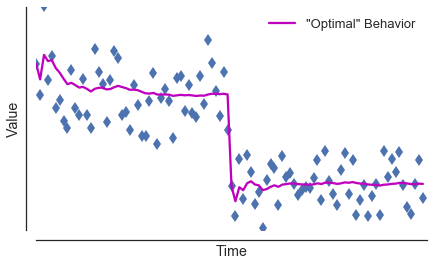

In [12]:
# create a simple RL Agent
XY = np.concatenate([X, Y])
mle = [
    np.mean(X[0:ii]) for ii in range(1, len(X) + 1)] + [np.mean(Y[0:ii]) for ii in range(1, len(Y) + 1)]



v = 10
eta = 0.25
q = []
for X0 in XY:
    q.append(v)
    v += eta *(X0 - v)
    

with sns.axes_style('ticks'):
    plt.figure(figsize=(7, 4))
    plt.plot(XY, 'd')
    plt.plot(mle, 'm', label='"Optimal" Behavior')
#     plt.plot(q, 'k', label='Learning Rate = 0.25')
    ax = plt.gca()
    ax.set_ylim([0, 25])
    ax.set_yticks([])
    ax.set_xticks([])
    sns.despine(trim=True, offset=10)
    ax.set_ylabel('Value')
    ax.set_xlabel('Time')
    plt.legend()
    plt.savefig('D10.png', dpi=300)

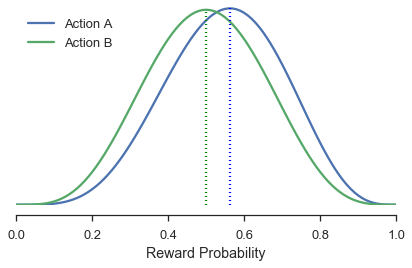

In [15]:
from scipy.stats import beta



a = 5.5
b = 4.5
mode_a = (a - 1.) / (a + b -2.)
rv = beta(a, b)



a = 5
b = 5
mode_b = (a - 1.) / (a + b -2.)
rv2 = beta(a, b)

x = np.arange(0, 1.01, 0.01)
with sns.axes_style('ticks'):
    plt.figure(figsize=(6, 4))
    plt.plot(x, rv.pdf(x), label='Action A')
    plt.plot(x, rv2.pdf(x), label='Action B')
    
    ax = plt.gca()
    lb, ub = ax.get_ylim()
    plt.plot([mode_a, mode_a], [lb, rv.pdf(mode_a)], 'b:')

    plt.plot([mode_b, mode_b], [lb, rv2.pdf(mode_b)], 'g:')

    
    ax.set_yticks([])
    ax.set_xlabel('Reward Probability')
    sns.despine(offset=10, left=True)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.savefig('D11.png', dpi=300)

In [16]:
cmf = rv.cdf(x)
cmf2 = rv2.cdf(x)


# y = []
y = [x[np.sum(cmf < np.random.rand())] > x[np.sum(cmf2 < np.random.rand())] for _ in range(1000)]
# y2 = [x[np.sum(cmf2 < np.random.rand())] for _ in range(1000)]

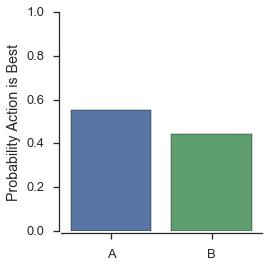

In [19]:
with sns.axes_style('ticks'):
    plt.figure(figsize=(4,4))
    sns.barplot([1, 2], [np.sum(y)*1./len(y), (len(y) - np.sum(y))*1./len(y)])
    
    ax = plt.gca()
    ax.set_xticklabels(['A', 'B'])
    ax.set_ylabel('Probability Action is Best')
    ax.set_ylim(0, 1)
    sns.despine(offset=2)
    plt.tight_layout()


In [18]:
x[np.sum(cmf2 < np.random.rand())]

0.78000000000000003